In [3]:
%matplotlib inline

import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff


# Simulate Data

In [1]:
import importlib
import simulate_data
importlib.reload(simulate_data)

<module 'simulate_data' from '/Users/hwunrow/Documents/GitHub/rt-estimation/src/simulate_data.py'>

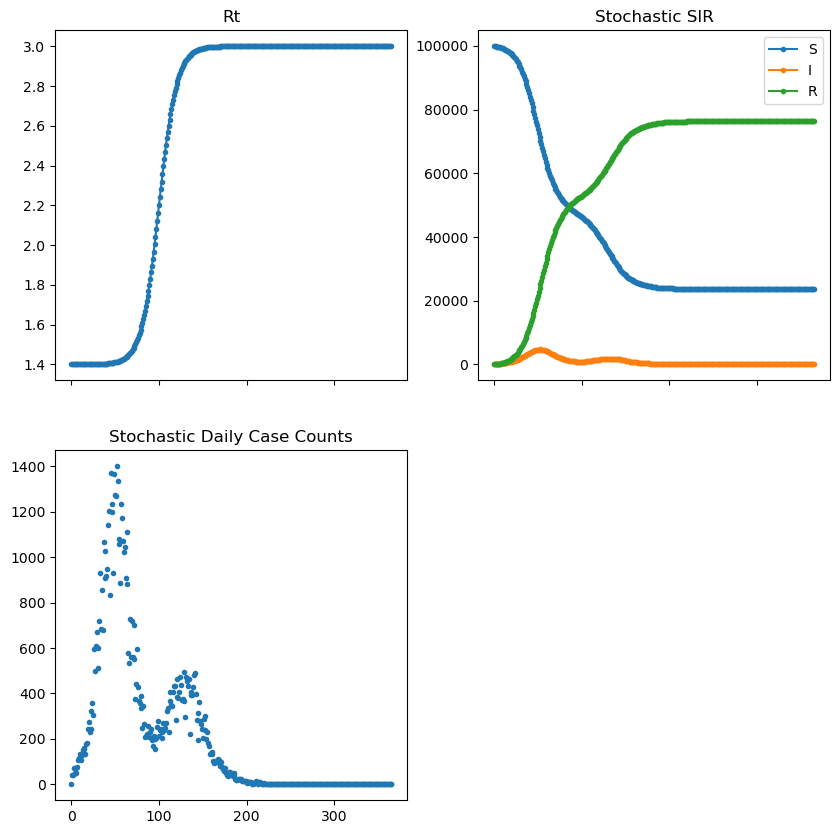

In [4]:
true_params = {
    'rt_0': 1.4,
    'rt_1': 3.,
    'midpoint': 100.,
    'k': 0.1,
    'n_t': 365,
    't_I': 4.,
    'N': 100_000.,
    'S0': 99_900.,
    'I0': 100.,
}


np.random.seed(1994)

# data = simulate_data.simulate_data(**true_params, run_deterministic=True)

data = simulate_data.simulate_data(**true_params, add_noise=True, noise_param=1/50)

data.plot_all()

# Ensemble Kalman Filter

In [5]:
class EnsembleKalmanFilter():
    """
    Parameters
    ----------

    x : np.array(dim_x)
        state mean

    P : np.array((dim_x, dim_x))
        covariance of the state

    dim_z : int
        Number of of measurement inputs. For example, if the sensor
        provides you with position in (x,y), dim_z would be 2.

    dt : float
        time step

    N : int
        number of ensembles. Must be greater than 1.

    K : np.array
        Kalman gain

    hx : function hx(x)
        Measurement function. May be linear or nonlinear - converts state
        x into a measurement. Return must be an np.array of the same
        dimensionality as the measurement vector.

    fx : function fx(x, dt)
        State transition function. May be linear or nonlinear. Projects
        state x into the next time period. Returns the projected state x
    """

    def __init__(self, x, P, dim_z, dt, N, hx, fx):
        if dim_z <= 0:
            raise ValueError('dim_z must be greater than zero')

        if N <= 0:
            raise ValueError('N must be greater than zero')

        dim_x = len(x)
        self.dim_x = dim_x
        self.dim_z = dim_z
        self.dt = dt
        self.N = N
        self.hx = hx
        self.fx = fx
        self.K = np.zeros((dim_x, dim_z))
        self.z = np.array([[None]*self.dim_z]).T
        self.S = np.zeros((dim_z, dim_z))   # system uncertainty
        self.SI = np.zeros((dim_z, dim_z))  # inverse system uncertainty

        self.initialize(x, P)
        self.Q = eye(dim_x)       # process uncertainty
        self.R = eye(dim_z)       # state uncertainty
        self.inv = np.linalg.inv

        # used to create error terms centered at 0 mean for state and measurement
        self._mean = np.zeros(dim_x)
        self._mean_z = np.zeros(dim_z)
    
    def initialize(self, x, P):
        """
        Initializes the filter with the specified mean and
        covariance. Only need to call this if you are using the filter
        to filter more than one set of data; this is called by __init__

        Parameters
        ----------

        x : np.array(dim_z)
            state mean

        P : np.array((dim_x, dim_x))
            covariance of the state
        """

        if x.ndim != 1:
            raise ValueError('x must be a 1D array')

        self.sigmas = multivariate_normal(mean=x, cov=P, size=self.N)
        self.x = x
        self.P = P

        # these will always be a copy of x,P after predict() is called
        self.x_prior = self.x.copy()
        self.P_prior = self.P.copy()

        # these will always be a copy of x,P after update() is called
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()


    def update(self, z, R=None):
        """
        Add a new measurement (z) to the kalman filter. If z is None, nothing
        is changed.

        Parameters
        ----------

        z : np.array
            measurement for this update.

        R : np.array, scalar, or None
            Optionally provide R to override the measurement noise for this
            one call, otherwise  self.R will be used.
        """

        if z is None:
            self.z = np.array([[None]*self.dim_z]).T
            self.x_post = self.x.copy()
            self.P_post = self.P.copy()
            return

        if R is None:
            R = self.R
        if np.isscalar(R):
            R = eye(self.dim_z) * R

        N = self.N
        dim_z = len(z)
        sigmas_h = zeros((N, dim_z))

        # transform sigma points into measurement space
        for i in range(N):
            sigmas_h[i] = self.hx(self.sigmas[i])

        z_mean = np.mean(sigmas_h, axis=0)

        P_zz = 0
        for sigma in sigmas_h:
            s = sigma - z_mean
            P_zz += outer(s, s)
        P_zz = P_zz / (N-1) + R
        self.S = P_zz
        self.SI = self.inv(self.S)


        P_xz = 0
        for i in range(N):
            P_xz += outer(self.sigmas[i] - self.x, sigmas_h[i] - z_mean)
        P_xz /= N-1

        self.K = dot(P_xz, self.inv(P_zz))

        e_r = multivariate_normal(self._mean_z, R, N)
        for i in range(N):
            self.sigmas[i] += dot(self.K, z + e_r[i] - sigmas_h[i])

        self.x = np.mean(self.sigmas, axis=0)
        self.P = self.P - dot(dot(self.K, P_zz), self.K.T)

        # save measurement and posterior state
        self.z = deepcopy(z)
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()


    def predict(self):
        """ Predict next position. """

        N = self.N
        for i, s in enumerate(self.sigmas):
            self.sigmas[i] = self.fx(s, self.dt)

        e = multivariate_normal(self._mean, self.Q, N)
        self.sigmas += e

        P = 0
        for s in self.sigmas:
            sx = s - self.x
            P += outer(sx, sx)

        self.P = P / (N-1)

        # save prior
        self.x_prior = np.copy(self.x)
        self.P_prior = np.copy(self.P)


    def __repr__(self):
        return '\n'.join([
            'EnsembleKalmanFilter object',
            pretty_str('dim_x', self.dim_x),
            pretty_str('dim_z', self.dim_z),
            pretty_str('dt', self.dt),
            pretty_str('x', self.x),
            pretty_str('P', self.P),
            pretty_str('x_prior', self.x_prior),
            pretty_str('P_prior', self.P_prior),
            pretty_str('Q', self.Q),
            pretty_str('R', self.R),
            pretty_str('K', self.K),
            pretty_str('S', self.S),
            pretty_str('sigmas', self.sigmas),
            pretty_str('hx', self.hx),
            pretty_str('fx', self.fx)
            ])
    

# Archize

## SIR Dynamics

\begin{array}{l}
\frac{d S}{d t}=-\frac{\beta(t) I S}{N} \\
\frac{d I}{d t}=\frac{\beta(t) I S}{N}-\gamma I, \\
\frac{d R}{d t}=\gamma I
\end{array}.

In [5]:
SIR = collections.namedtuple(
  typename='SIRComponents',
  field_names=[
    'susceptible',              # S
    'infectious',               # I
    'recovered',                # R
    'daily_new_documented_infectious'])

ModelParams = collections.namedtuple(
    typename='ModelParams',
    field_names=[
      'beta',                        # Beta
      'average_infection_duration'   # D = 1/gamma
    ]
)

In [6]:
def sample_state_deltas(
    state, population, params, seed, is_deterministic=False):
  """Computes one-step change in state, including Poisson sampling.
  
  Note that this is coded to support vectorized evaluation on arbitrary-shape
  batches of states.  This is useful, for example, for running multiple
  independent replicas of this model to compute credible intervals for the
  parameters.  We refer to the arbitrary batch shape with the conventional
  `B` in the parameter documentation below.  This function also, of course,
  supports broadcasting over the batch shape.

  Args:
    state: A `SIRComponents` tuple with fields Tensors of shape
      B + [num_locations] giving the current disease state.
    population: A Tensor of shape B + [num_locations] giving the current city
      populations.
    params: A `ModelParams` tuple with fields Tensors of shape B giving the
      global parameters for the current EAKF run.
    seed: Initial entropy for pseudo-random number generation.  The Poisson
      sampling is repeatable by supplying the same seed.
    is_deterministic: A `bool` flag to turn off Poisson sampling if desired.

  Returns:
    delta: A `SIRComponents` tuple with fields Tensors of shape
      B + [num_locations] giving the one-day changes in the state, according
      to equations 1-4 above (including Poisson noise per Li et al).
  """
  infectious_fraction = state.infectious / population

  # Helper for sampling the Poisson-variate terms.
  seeds = samplers.split_seed(seed, n=11)
  if is_deterministic:
    def sample_poisson(rate):
      return rate
  else:
    def sample_poisson(rate):
      return tfd.Poisson(rate=rate).sample(seed=seeds.pop())

  dSI = sample_poisson(params.beta * infectious_fraction * state.susceptible)
  dIR = sample_poisson(state.infectious / params.average_infection_duration)

  # The final state_deltas
  return SIRComponents(
      susceptible=-dSI,
      infectious=dSI - dIR,
      recovered=dIR,
      daily_new_documented_infectious=dSI)

In [8]:
@tf.function(autograph=False)
def rk4_one_step(state, population, mobility_matrix, params, seed):
  """Implement one step of RK4, wrapped around a call to sample_state_deltas."""
  # One seed for each RK sub-step
  seeds = samplers.split_seed(seed, n=4)

  deltas = tf.nest.map_structure(tf.zeros_like, state)
  combined_deltas = tf.nest.map_structure(tf.zeros_like, state)

  for a, b in zip([1., 2, 2, 1.], [6., 3., 3., 6.]):
    next_input = tf.nest.map_structure(
        lambda x, delta, a=a: x + delta / a, state, deltas)
    deltas = sample_state_deltas(
        next_input,
        population,
        params,
        seed=seeds.pop(), is_deterministic=False)
    combined_deltas = tf.nest.map_structure(
        lambda x, delta, b=b: x + delta / b, combined_deltas, deltas)

  return tf.nest.map_structure(
      lambda s, delta: s + tf.round(delta),
      state, combined_deltas)

In [9]:
def initialize_state(num_particles, num_batches, seed):
  """Initialize the state for a batch of EAKF runs.
  
  Args:
    num_particles: `int` giving the number of particles for the EAKF.
    num_batches: `int` giving the number of independent EAKF runs to
      initialize in a vectorized batch.
    seed: PRNG entropy.
    
  Returns:
    state: A `SIRComponents` tuple with Tensors of shape [num_particles,
      num_batches, num_cities] giving the initial conditions in each
      city, in each filter particle, in each batch member.
  """
  state_shape = [num_particles, num_batches]
  susceptible = initial_population * np.ones(state_shape, dtype=np.float32)
  infectious = np.zeros(state_shape, dtype=np.float32)
  daily_new_documented_infectious = np.zeros(state_shape, dtype=np.float32)

  # Following Li et al, initialize Wuhan with up to 2000 people exposed
  # and another up to 2000 undocumented infectious.
  rng = np.random.RandomState(seed[0] % (2**31 - 1))
  wuhan_exposed = rng.randint(
      0, 2001, [num_particles, num_batches]).astype(np.float32)
  wuhan_undocumented_infectious = rng.randint(
      0, 2001, [num_particles, num_batches]).astype(np.float32)
 
  # Also following Li et al, initialize cities adjacent to Wuhan with three
  # days' worth of additional exposed and undocumented-infectious cases,
  # as they may have traveled there before the beginning of the modeling
  # period.
  exposed = 3 * mobility_matrix_over_time[
      WUHAN_IDX, :, 0] * wuhan_exposed[
          ..., np.newaxis] / initial_population[WUHAN_IDX]
  undocumented_infectious = 3 * mobility_matrix_over_time[
      WUHAN_IDX, :, 0] * wuhan_undocumented_infectious[
          ..., np.newaxis] / initial_population[WUHAN_IDX]

  exposed[..., WUHAN_IDX] = wuhan_exposed
  undocumented_infectious[..., WUHAN_IDX] = wuhan_undocumented_infectious

  # Following Li et al, we do not remove the initial exposed and infectious
  # persons from the susceptible population.
  return SIRComponents(
      susceptible=tf.constant(susceptible),
      exposed=tf.constant(exposed),
      documented_infectious=tf.constant(documented_infectious),
      undocumented_infectious=tf.constant(undocumented_infectious),
      daily_new_documented_infectious=tf.constant(daily_new_documented_infectious))

def update_params(num_particles, num_batches,
                  prev_params, parameter_variance, seed):
  """Update the global parameters between EAKF runs.

  Args:
    num_particles: `int` giving the number of particles for the EAKF.
    num_batches: `int` giving the number of independent EAKF runs to
      initialize in a vectorized batch.
    prev_params: A `ModelParams` tuple of the parameters used for the previous
      EAKF run.
    parameter_variance: A `ModelParams` tuple specifying how much to drift
      each parameter.
    seed: PRNG entropy.
    
  Returns:
    params: A `ModelParams` tuple with fields Tensors of shape
      [num_particles, num_batches] giving the global parameters
      to use for the next batch of EAKF runs.
  """
  # Initialize near the previous set of parameters. This is the first step
  # in Iterated Filtering.
  seeds = tf.nest.pack_sequence_as(
      prev_params, samplers.split_seed(seed, n=len(prev_params)))
  return tf.nest.map_structure(
      lambda x, v, seed: x + tf.math.sqrt(v) * tf.random.stateless_normal([
          num_particles, num_batches, 1], seed=seed),
      prev_params, parameter_variance, seeds)